In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings
import pandas as pd
import numpy as np
import random
from collections import defaultdict
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Importing & Preparing Data

In [2]:
twitter_df = pd.read_csv('edgelist.csv')
hateful_user_df = pd.read_csv('hateful_users.csv')

# Filter out rows where src and dst are the same
filtered_twitter_df = twitter_df[twitter_df['src'] != twitter_df['dst']]

# Identify the excluded user IDs in twitter_df
excluded_ids = set(twitter_df['src']) - set(filtered_twitter_df['src'])
excluded_ids.update(set(twitter_df['dst']) - set(filtered_twitter_df['dst']))

# Filter out these user IDs from hateful_user_df
filtered_hateful_user_df = hateful_user_df[~hateful_user_df['user_id'].isin(excluded_ids)]

In [3]:
filtered_hateful_user_df.head(3)

,user_id,producer,consumer,outdegree,indegree,degree,outstrength,instrength,strength,n_tweets,n_hate_tweets,n_northerner_tweets,n_hausa_tweets,n_fulani_tweets,n_southerner_tweets,n_yoruba_tweets,n_biafra_tweets,n_igbo_tweets,n_retweets,n_hate_retweets,n_northerner_retweets,n_hausa_retweets,n_fulani_retweets,n_southerner_retweets,n_yoruba_retweets,n_biafra_retweets,n_igbo_retweets,n_likes,n_hate_likes,n_northerner_likes,n_hausa_likes,n_fulani_likes,n_southerner_likes,n_yoruba_likes,n_biafra_likes,n_igbo_likes,ethnicity,religion,gender,user_timestamp,user_followers_count,user_friends_count,user_statuses_count,user_favourites_count,user_verified,sampling_proportion_likes,sampling_proportion_timelines
0,11172,1.0,1.0,7,11,16,11.0,98.0,109.0,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1016,10,10,0,0,0,0,0,0,NaN,NaN,NaN,1.162282e+09,259.0,334.0,2544.0,32294.0,False,0.029260,0.998249
1,2340131,1.0,1.0,1141,5,1008,1541.0,5.0,1546.0,106,3,1,0,2,0,0,0,0,78,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,igbo,christian,m,1.174936e+09,5301.0,665.0,1274.0,162.0,False,0.984909,0.998249
2,3741461,1.0,1.0,2,2,2,13.0,3.0,16.0,100,0,0,0,0,0,0,0,0,812,0,0,0,0,0,0,0,0,3139,2,2,0,0,0,0,0,0,NaN,NaN,NaN,1.175985e+09,637.0,742.0,5782.0,11655.0,False,0.951123,0.998249


In [4]:
filtered_twitter_df.head(3)

,dst,src,n_mentions,n_retweets,n_tweets
0,1642207375,1304915551467208707,4.0,4.0,4.0
1,703569617,985075589995524096,2.0,0.0,2.0
4,1331088135825010690,1343310549061406720,5.0,0.0,5.0


### Utility Functions

In [5]:
def remove_nodes_with_few_connections(subgraph, min_degree=4):
    # Nodes to be removed
    nodes_to_remove = [node for node in subgraph.nodes if subgraph.degree(node) < min_degree]

    # Remove these nodes from the subgraph
    subgraph.remove_nodes_from(nodes_to_remove)

    return subgraph

def get_random_subset(G, num_nodes):
    # Ensure that the number of nodes requested is not more than the number of nodes in the graph
    num_nodes = min(num_nodes, len(G.nodes))

    # Select a random subset of nodes
    random_nodes = random.sample(G.nodes(), num_nodes)

    # Create a subgraph with the selected nodes
    random_subset_graph = G.subgraph(random_nodes).copy()
    return random_subset_graph

In [6]:
def draw_graph_spring(G, cat_df, attribute_name):
    # Get the values of the category
    cat_values = cat_df[cat_df.index.isin(G.nodes)][attribute_name].unique()
    colors = [plt.cm.Set2(i/float(len(cat_values)-1)) for i in range(len(cat_values))]

    # Create a dictionary mapping category values to colors & map nodes to colors
    value_to_color = dict(zip(cat_values, colors))
    node_colors = [value_to_color[cat_df.loc[n][attribute_name]] for n in G.nodes() if n in cat_df.index]

    # Calculate the layout positions using the spring layout
    positions = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(15, 15))
    nx.draw(G, pos=positions, node_size=25, node_color=node_colors, with_labels=False)

    # Create a patch for each category value for the legend
    patches = [plt.plot([],[], marker="o", color=color, 
                        label=str(value), linestyle='None')[0] for value, color in value_to_color.items()]

    # Add legend
    plt.legend(handles=patches, title=attribute_name)

    # Display the plot
    plt.show()

### Clustering by `ethnicity`

In [7]:
def get_connected_subset_by_ethnicity(G, num_nodes):
    # Ensure at least 5% nodes for each ethnicity
    min_nodes_per_ethnicity = int(num_nodes * 0.05)

    # Filter nodes by ethnicity
    nodes_igbo = [node for node, attr in G.nodes(data=True) if attr.get('ethnicity') == 'igbo']
    nodes_yoruba = [node for node, attr in G.nodes(data=True) if attr.get('ethnicity') == 'yoruba']
    nodes_hausa = [node for node, attr in G.nodes(data=True) if attr.get('ethnicity') == 'hausa']

    # Calculate the number of nodes for each ethnicity
    num_igbo = max(min_nodes_per_ethnicity, len(nodes_igbo))
    num_yoruba = max(min_nodes_per_ethnicity, len(nodes_yoruba))
    num_hausa = max(min_nodes_per_ethnicity, len(nodes_hausa))

    # Adjust the numbers if the total exceeds num_nodes
    total_num = num_igbo + num_yoruba + num_hausa
    while total_num > num_nodes:
        # Reduce the count of the largest group
        if num_igbo > num_yoruba and num_igbo > num_hausa:
            num_igbo -= 1
        elif num_yoruba > num_igbo and num_yoruba > num_hausa:
            num_yoruba -= 1
        else:
            num_hausa -= 1
        total_num = num_igbo + num_yoruba + num_hausa

    # Get connected components for each ethnicity
    components_igbo = [G.subgraph(c).copy() for c in nx.connected_components(G.subgraph(nodes_igbo))]
    components_yoruba = [G.subgraph(c).copy() for c in nx.connected_components(G.subgraph(nodes_yoruba))]
    components_hausa = [G.subgraph(c).copy() for c in nx.connected_components(G.subgraph(nodes_hausa))]

    # Sort connected components by size
    components_igbo.sort(key=len, reverse=True)
    components_yoruba.sort(key=len, reverse=True)
    components_hausa.sort(key=len, reverse=True)

    # Select the largest connected components for each ethnicity
    largest_cc_igbo = components_igbo[0] if components_igbo else None
    largest_cc_yoruba = components_yoruba[0] if components_yoruba else None
    largest_cc_hausa = components_hausa[0] if components_hausa else None

    # Select top nodes by degree within each ethnicity
    selected_nodes_igbo = sorted(largest_cc_igbo.nodes, key=lambda node: G.degree(node), reverse=True)[:num_igbo] if largest_cc_igbo else []
    selected_nodes_yoruba = sorted(largest_cc_yoruba.nodes, key=lambda node: G.degree(node), reverse=True)[:num_yoruba] if largest_cc_yoruba else []
    selected_nodes_hausa = sorted(largest_cc_hausa.nodes, key=lambda node: G.degree(node), reverse=True)[:num_hausa] if largest_cc_hausa else []

    # Create a subgraph with the selected nodes
    selected_nodes = selected_nodes_igbo + selected_nodes_yoruba + selected_nodes_hausa
    subset_graph = G.subgraph(selected_nodes)
    largest_cc = max(nx.connected_components(subset_graph), key=len, default=set())
    subset_graph = subset_graph.subgraph(largest_cc).copy()

    return subset_graph

In [8]:
filtered_hateful_user_df_ethnicity_na_dropped = filtered_hateful_user_df.dropna(subset=['ethnicity'])
cat_df = filtered_hateful_user_df_ethnicity_na_dropped.set_index('user_id')['ethnicity'].to_frame()

# Rename the column
cat_df.columns = ['ethnicity']

In [9]:
# Remove rows in twitter_df where either 'src' or 'dst' is not in the list of user IDs with non-missing 'ethnicity'
valid_user_ids = set(filtered_hateful_user_df_ethnicity_na_dropped['user_id'])
filtered_edges = filtered_twitter_df[
    filtered_twitter_df['src'].isin(valid_user_ids) & 
    filtered_twitter_df['dst'].isin(valid_user_ids)
]

# Now create the graph
G = nx.from_pandas_edgelist(filtered_edges, 'src', 'dst')

In [10]:
for node in G.nodes:
    G.nodes[node]['ethnicity'] = cat_df.get(node, None)

G_random_subset = get_random_subset(G, 2000)
G_random_subset = remove_nodes_with_few_connections(G_random_subset, min_degree=3)
# draw_graph_spring(G_random_subset, cat_df, 'ethnicity')

### Clustering by `n_tweets`

In [11]:
def get_connected_subset_by_tweet_category(G, num_nodes):
    # Minimum representation for each category
    min_rep = int(num_nodes * 0.1)

    # Filter nodes by tweet category
    category_nodes = defaultdict(list)
    for node, data in G.nodes(data=True):
        category = data.get('tweet_category')
        category_nodes[category].append(node)

    # Ensure at least 10% nodes for each category
    for category in category_nodes:
        category_nodes[category] = random.sample(category_nodes[category], 
                                                 max(min_rep, len(category_nodes[category])))

    # Start from a random node
    start_node = random.choice(list(G.nodes()))
    visited = set([start_node])
    queue = [start_node]

    # Use tqdm for progress tracking
    with tqdm(total=num_nodes, desc="Building Subset") as pbar:
        while len(visited) < num_nodes and queue:
            current = queue.pop(0)
            neighbors = [n for n in G.neighbors(current) if n not in visited]

            # Randomize neighbors
            random.shuffle(neighbors)

            for neighbor in neighbors:
                # Add neighbor if it maintains the 10% representation
                neighbor_category = G.nodes[neighbor].get('tweet_category')
                if len([n for n in visited if G.nodes[n].get('tweet_category') == neighbor_category]) < min_rep or \
                   len(visited) + len(queue) < num_nodes:
                    visited.add(neighbor)
                    queue.append(neighbor)
                    pbar.update(1)

                if len(visited) >= num_nodes:
                    break

    # Create the subgraph
    subset_graph = G.subgraph(visited).copy()

    return subset_graph

In [12]:
filtered_hateful_user_df['tweet_category'], bins = pd.qcut(filtered_hateful_user_df['n_tweets'], 3, labels=['low', 'medium', 'high'], retbins=True)
cat_df = filtered_hateful_user_df[['user_id', 'tweet_category']].set_index('user_id')

# Create a set of user IDs from the filtered_hateful_user_df
hateful_users_set = set(filtered_hateful_user_df['user_id'])

# Filter the filtered_twitter_df to keep only rows where both src and dst are in hateful_users_set
filtered_twitter_included_df = filtered_twitter_df[
    filtered_twitter_df['src'].isin(hateful_users_set) & 
    filtered_twitter_df['dst'].isin(hateful_users_set)
]

G = nx.from_pandas_edgelist(filtered_twitter_included_df, 'src', 'dst')

In [13]:
len(G.nodes), len(hateful_users_set)

(77221, 77247)

In [14]:
for node in tqdm(G.nodes, desc='Assigning Categories'):
    node_category = cat_df.loc[node, 'tweet_category'] if node in cat_df.index else None
    G.nodes[node]['tweet_category'] = node_category

Assigning Categories:   0%|          | 0/77221 [00:00<?, ?it/s]

In [15]:
G_subset = get_connected_subset_by_tweet_category(G, 2000)

Building Subset:   0%|          | 0/2000 [00:00<?, ?it/s]

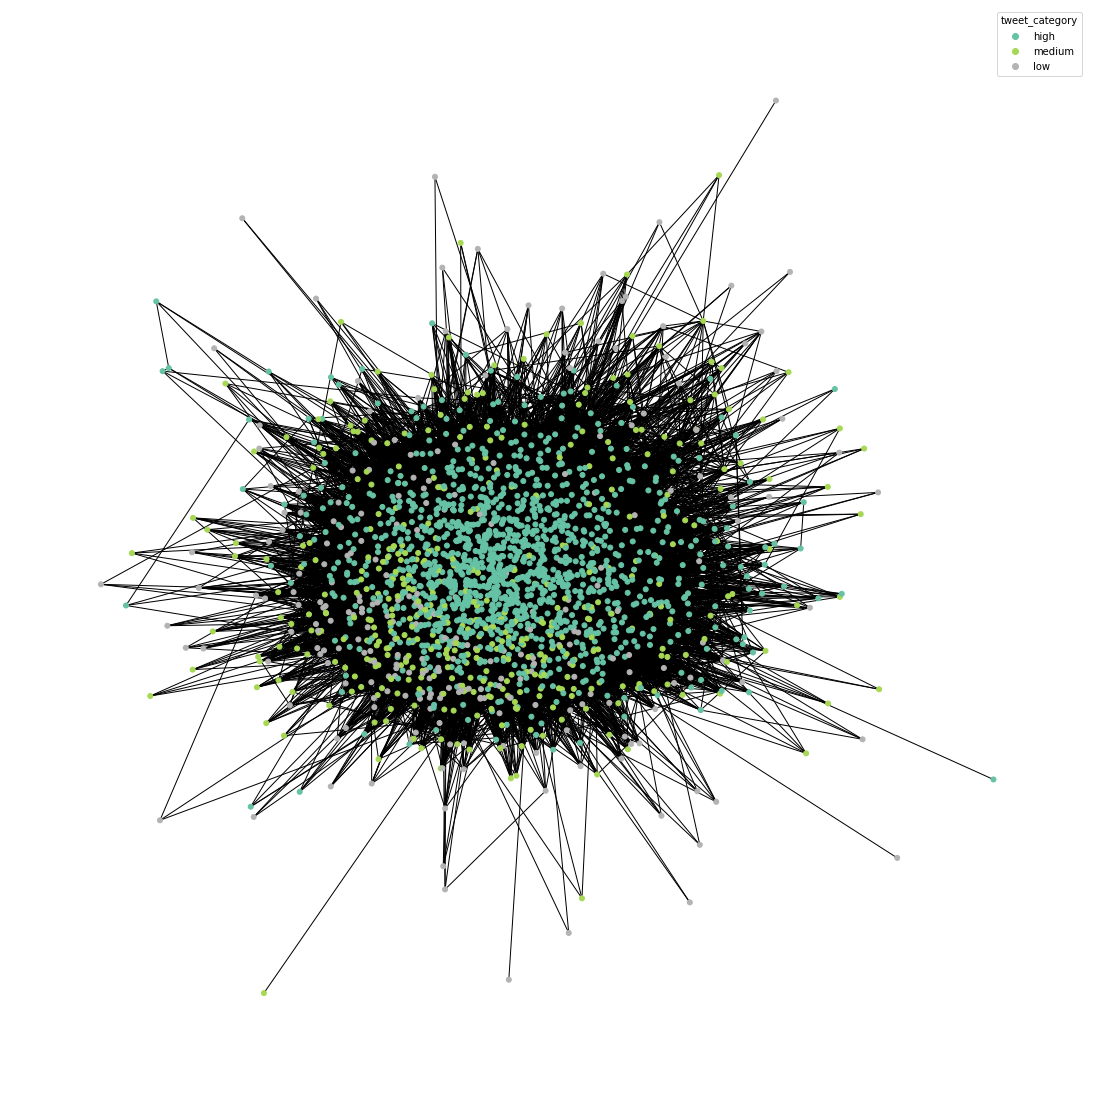

In [16]:
draw_graph_spring(G_subset, cat_df, 'tweet_category')

```
# Create a set of all unique user IDs in filtered_twitter_df (both src and dst)
twitter_users_set = set(filtered_twitter_df['src']).union(set(filtered_twitter_df['dst']))

# Find users in hateful_users_set who are not in twitter_users_set
isolated_users = hateful_users_set - twitter_users_set

# Count of isolated users
len(isolated_users) 
```

### Clustering by ethnicity tweeted at

In [22]:
def get_connected_subset_by_ethnicity_tweeted_at(G, num_nodes):
    # Ensure at least 5% nodes for each ethnicity tweeted at
    min_nodes_per_ethnicity = int(num_nodes * 0.05)

    # Filter nodes by ethnicity tweeted at
    ethnicity_nodes = defaultdict(list)
    for node, data in G.nodes(data=True):
        ethnicity = data.get('ethnicity_tweeted_at')
        ethnicity_nodes[ethnicity].append(node)

    # Ensure at least 5% nodes for each ethnicity
    for ethnicity in ethnicity_nodes:
        ethnicity_nodes[ethnicity] = random.sample(ethnicity_nodes[ethnicity], 
                                                   max(min_nodes_per_ethnicity, len(ethnicity_nodes[ethnicity])))

    # Start from a random node
    start_node = random.choice(list(G.nodes()))
    visited = set([start_node])
    queue = [start_node]

    # Use tqdm for progress tracking
    with tqdm(total=num_nodes, desc="Building Subset") as pbar:
        while len(visited) < num_nodes and queue:
            current = queue.pop(0)
            neighbors = [n for n in G.neighbors(current) if n not in visited]

            # Randomize neighbors
            random.shuffle(neighbors)

            for neighbor in neighbors:
                # Add neighbor if it maintains the 5% representation
                neighbor_ethnicity = G.nodes[neighbor].get('ethnicity_tweeted_at')
                if len([n for n in visited if G.nodes[n].get('ethnicity_tweeted_at') == neighbor_ethnicity]) < min_nodes_per_ethnicity or \
                   len(visited) + len(queue) < num_nodes:
                    visited.add(neighbor)
                    queue.append(neighbor)
                    pbar.update(1)

                if len(visited) >= num_nodes:
                    break

    # Create the subgraph
    subset_graph = G.subgraph(visited).copy()

    return subset_graph

In [17]:
# Add relevant column to filtered_hateful_users_df
def find_max_ethnicity(row):
    # Create a dictionary with ethnicity as keys and tweet counts as values
    ethnicities = {
        'northerner': row['n_northerner_tweets'],
        'hausa': row['n_hausa_tweets'],
        'fulani': row['n_fulani_tweets'],
        'southerner': row['n_southerner_tweets'],
        'yoruba': row['n_yoruba_tweets'],
        'biafra': row['n_biafra_tweets'],
        'igbo': row['n_igbo_tweets']
    }
    
    # Find the maximum value and corresponding key (ethnicity)
    max_ethnicity = max(ethnicities, key=ethnicities.get)
    max_value = ethnicities[max_ethnicity]

    # Return the ethnicity with the maximum value or "N/A" if all are zero
    return max_ethnicity if max_value != 0 else "N/A"

# Apply the function to each row
filtered_hateful_user_df['ethnicity_tweeted_at'] = filtered_hateful_user_df.apply(find_max_ethnicity, axis=1)

In [18]:
filtered_hateful_user_df_ethnicity_tweeted_at_na_dropped = filtered_hateful_user_df.dropna(subset=['ethnicity_tweeted_at'])
cat_df = filtered_hateful_user_df_ethnicity_tweeted_at_na_dropped.set_index('user_id')['ethnicity_tweeted_at'].to_frame()

In [19]:
# Create a set of user IDs from the filtered_hateful_user_df
hateful_users_set = set(filtered_hateful_user_df_ethnicity_tweeted_at_na_dropped['user_id'])

# Filter the filtered_twitter_df to keep only rows where both src and dst are in hateful_users_set
filtered_twitter_included_df = filtered_twitter_df[
    filtered_twitter_df['src'].isin(hateful_users_set) & 
    filtered_twitter_df['dst'].isin(hateful_users_set)
]

G = nx.from_pandas_edgelist(filtered_twitter_included_df, 'src', 'dst')

In [27]:
for node in tqdm(G.nodes, desc='Assigning Categories'):
    node_category = cat_df.loc[node, 'ethnicity_tweeted_at'] if node in cat_df.index else None
    G.nodes[node]['tweet_category'] = node_category

Assigning Categories:   0%|          | 0/77221 [00:00<?, ?it/s]

Building Subset:   0%|          | 0/2000 [00:00<?, ?it/s]

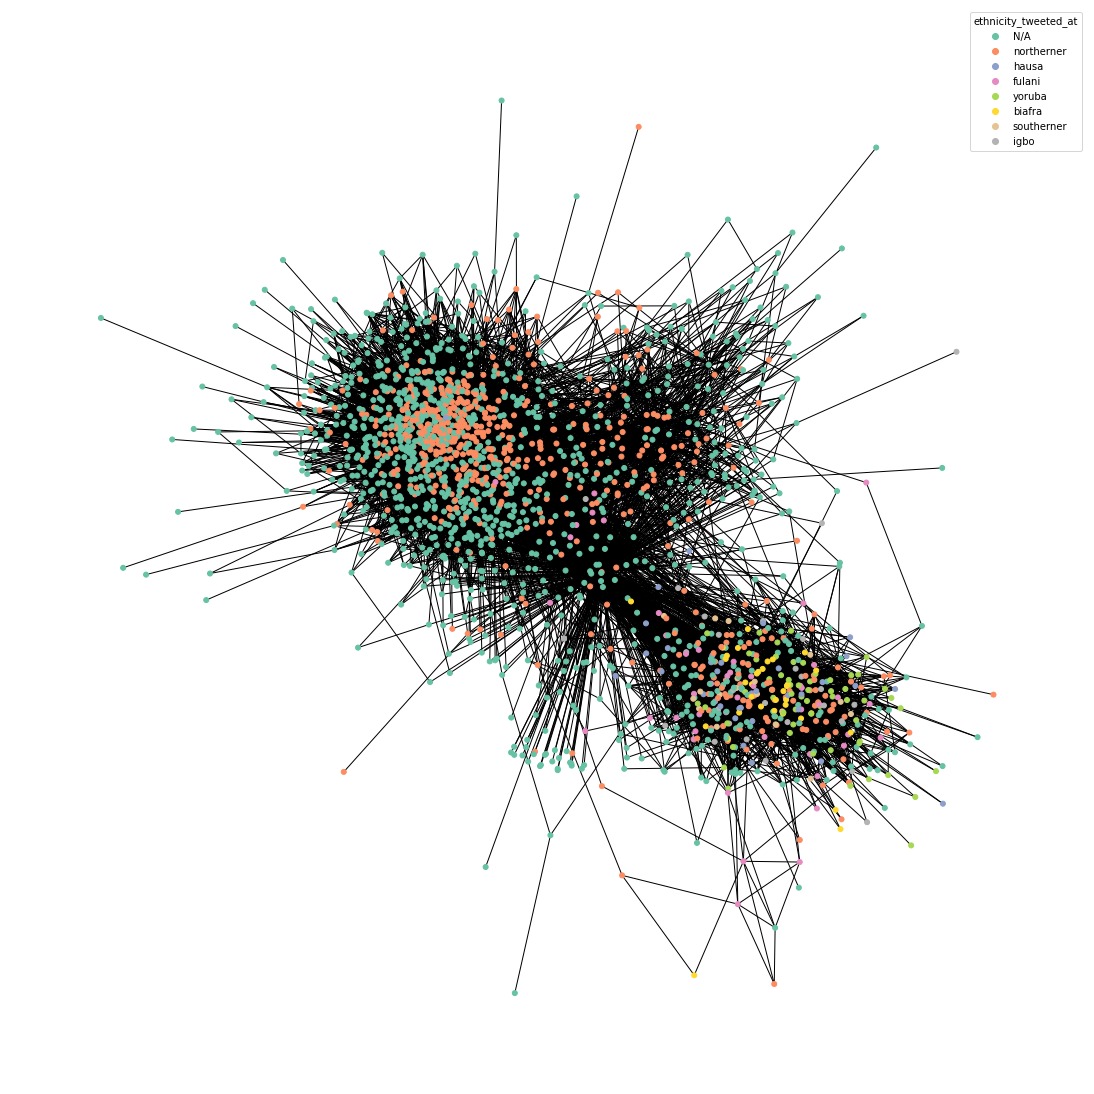

In [28]:
G_subset = get_connected_subset_by_ethnicity_tweeted_at(G, 2000)
draw_graph_spring(G_subset, cat_df, 'ethnicity_tweeted_at')